In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.cm import viridis

In [2]:
df = pd.read_stata('assignment8.dta')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 820 entries, 0 to 819
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   store         820 non-null    float32
 1   chain         820 non-null    float32
 2   co_owned      820 non-null    float32
 3   state         820 non-null    float32
 4   southj        820 non-null    float32
 5   centralj      820 non-null    float32
 6   northj        820 non-null    float32
 7   pa1           820 non-null    float32
 8   pa2           820 non-null    float32
 9   shore         820 non-null    float32
 10  ncalls        571 non-null    float32
 11  empft         802 non-null    float32
 12  emppt         806 non-null    float32
 13  nmgrs         808 non-null    float32
 14  wage_st       779 non-null    float32
 15  inctime       723 non-null    float32
 16  firstinc      697 non-null    float32
 17  meals         809 non-null    float32
 18  open          809 non-null    

,store,chain,co_owned,state,southj,centralj,northj,pa1,pa2,shore,...,firstinc,meals,open,hoursopen,pricesoda,pricefry,priceentree,nregisters,nregisters11,time
0,46.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,NaN,2.0,6.5,16.5,1.03,1.03,0.52,3.0,3.0,0.0
1,49.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,NaN,2.0,10.0,13.0,1.01,0.90,2.35,4.0,3.0,0.0
2,506.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.37,2.0,11.0,10.0,0.95,0.74,2.33,3.0,3.0,0.0
3,56.0,4.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.10,2.0,10.0,12.0,0.87,0.82,1.79,2.0,2.0,0.0
4,61.0,4.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.15,3.0,10.0,12.0,0.87,0.77,1.65,2.0,2.0,0.0


# Exercise 1

In [3]:
# Examine the data structure and wage_st distribution
print("Total Count:", df.shape[0])
print("Unique values in 'time':", df.value_counts('time'))
print("Unique values in 'state':", df.value_counts('state'))
print("\nWage_st distribution:")
print(df['wage_st'].describe())
print("\nWage_st value counts:")

# Check for missing values
print(f"\nMissing values in wage_st: {df['wage_st'].isnull().sum()}")
print(f"Total observations: {len(df)}")

Total Count: 820
Unique values in 'time': time
0.0    410
1.0    410
Name: count, dtype: int64
Unique values in 'state': state
1.0    662
0.0    158
Name: count, dtype: int64

Wage_st distribution:
count    779.000000
mean       4.805712
std        0.358395
min        4.250000
25%        4.500000
50%        5.000000
75%        5.050000
max        6.250000
Name: wage_st, dtype: float64

Wage_st value counts:

Missing values in wage_st: 41
Total observations: 820


/var/folders/zq/p15018kx5fq6ftl0x9pxm9th0000gn/T/ipykernel_97591/305332354.py:26: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_s = df[df['time'] == i].assign(state=df['state'].map(state_map)).pivot_table(index='wage_bin_label', columns='state', aggfunc='size', fill_value=0)
/var/folders/zq/p15018kx5fq6ftl0x9pxm9th0000gn/T/ipykernel_97591/305332354.py:26: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_s = df[df['time'] == i].assign(state=df['state'].map(state_map)).pivot_table(index='wage_bin_label', columns='state', aggfunc='size', fill_value=0)


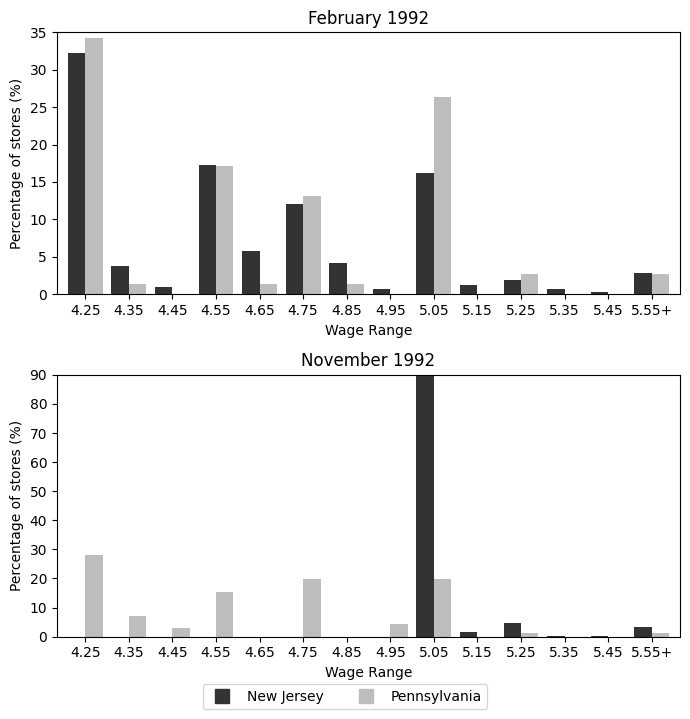

In [6]:
wave_map = {1:'November 1992', 0:'February 1992'}
state_map = {1:"New Jersey", 0:"Pennsylvania"}
bins = np.arange(4.20, 5.60, 0.1)
bins = np.append(bins, [np.inf])  # final bin is 5.55 and above
df['wage_bin'] = pd.cut(df['wage_st'], bins, right=False)
def _mid_label(iv):
    if pd.isnull(iv):
        return np.nan
    if iv.right == np.inf:
        mid = iv.left + 0.05  # half of the 0.1 bin width for the open-ended bin
        s = f"{mid:.2f}+"
    else:
        mid = (iv.left + iv.right) / 2
        s = f"{mid:.2f}"
    # remove unnecessary trailing zeros/decimal point
    if s.endswith('+'):
        base = s[:-1].rstrip('0').rstrip('.')
        return base + '+'
    return s.rstrip('0').rstrip('.')

df['wage_bin_label'] = df['wage_bin'].apply(_mid_label).astype('category')
colors = ["#353232", '#bdbdbd']
fig, axes = plt.subplots(2, 1, figsize=(7, 7), sharey=False)
for i in [0, 1]:

    pivot_s = df[df['time'] == i].assign(state=df['state'].map(state_map)).pivot_table(index='wage_bin_label', columns='state', aggfunc='size', fill_value=0)
    # convert counts to percentage of stores within each state (column-wise)
    pivot_pct = pivot_s.div(pivot_s.sum(axis=0), axis=1) * 100
    pivot_pct.plot(kind='bar', ax=axes[i], color=colors, width=0.8)
    axes[i].set_title(f'{wave_map[i]}')
    axes[i].set_xlabel('Wage Range')
    axes[i].set_ylabel('Percentage of stores (%)')
    axes[i].tick_params(axis='x', rotation=0)
    axes[i].get_legend().remove()
    # set different y-limits for the two plots
    if i == 0:
        axes[i].set_ylim(0, 35)
    else:
        axes[i].set_ylim(0, 90)

labels = pivot_pct.columns.tolist()
handles = [mlines.Line2D([], [], color=colors[i], marker='s', linestyle='None', markersize=10) for i in range(len(labels))]
fig.legend(handles=handles, labels=labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.03))

plt.tight_layout()
plt.savefig('Figure1.png', bbox_inches='tight')

# Exercise 1.2

In [7]:
#(Full-time-equivalent [FTE] employment was calculated as the number of full-time workers[including managers] 
# plus 0.5 times the number of part-time workers
#we assume that missing is 0
df['FTE'] = df['empft'] + df['nmgrs'] + 0.5 * df['emppt']

#for investigation
df['FTE2'] = df['empft'].fillna(0) + df['nmgrs'] + 0.5 * df['emppt']

In [8]:
df[df['FTE'].isnull() & ~df['wage_st'].isnull()][['time','store','empft','emppt','nmgrs','FTE2','wage_st']]

,time,store,empft,emppt,nmgrs,FTE2,wage_st
33,0.0,47.0,25.0,15.0,NaN,NaN,4.50
52,0.0,446.0,NaN,NaN,3.0,NaN,4.50
117,0.0,139.0,NaN,NaN,2.0,NaN,5.50
165,0.0,403.0,13.0,31.0,NaN,NaN,5.05
174,0.0,8.0,NaN,25.0,4.0,16.5,4.80
195,0.0,63.0,26.0,6.0,NaN,NaN,4.25
208,0.0,80.0,4.5,20.0,NaN,NaN,4.25
211,0.0,87.0,0.0,15.0,NaN,NaN,4.50
272,0.0,198.0,NaN,NaN,4.0,NaN,4.25
369,0.0,362.0,6.0,13.0,NaN,NaN,4.25


## Table 3 Row 1, 2, 3, 4 Columns Stores by State

In [9]:
#stores must be present in both waves to be included in the analysis
print("\nUnique stores by time and state (before cleaning):")
display(df.groupby(['time','state']).store.nunique())
print("\n Removing stores without FTE data in either wave...")
display(df.dropna(subset=['FTE']).groupby(['time','state']).store.nunique())
wave1_unique_stores = df.dropna(subset=['FTE'])[df['time']==0]['store'].unique()
wave2_unique_stores = df.dropna(subset=['FTE'])[df['time']==1]['store'].unique()

common_stores = np.intersect1d(wave1_unique_stores, wave2_unique_stores)
df_wFTE = df[df['store'].isin(common_stores)].dropna(subset=['FTE'])
display(df_wFTE.groupby(['time','state']).store.nunique())
print("Final number of stores included in the analysis:", df_wFTE['store'].nunique())


Unique stores by time and state (before cleaning):


time  state
0.0   0.0       79
      1.0      331
1.0   0.0       79
      1.0      331
Name: store, dtype: int64


 Removing stores without FTE data in either wave...


time  state
0.0   0.0       77
      1.0      321
1.0   0.0       77
      1.0      319
Name: store, dtype: int64

/var/folders/zq/p15018kx5fq6ftl0x9pxm9th0000gn/T/ipykernel_97591/1143379412.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  wave1_unique_stores = df.dropna(subset=['FTE'])[df['time']==0]['store'].unique()
/var/folders/zq/p15018kx5fq6ftl0x9pxm9th0000gn/T/ipykernel_97591/1143379412.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  wave2_unique_stores = df.dropna(subset=['FTE'])[df['time']==1]['store'].unique()


time  state
0.0   0.0       75
      1.0      309
1.0   0.0       75
      1.0      309
Name: store, dtype: int64

Final number of stores included in the analysis: 384


In [10]:
print("Average FTE by state and time, all observations")
stats = df.assign(state=df['state'].map(state_map)).groupby(["time","state"])["FTE"].mean().unstack()
stats['Difference'] = stats["New Jersey"] - stats["Pennsylvania"]
stats.loc['Difference'] = stats.loc[1] - stats.loc[0]
display(stats)
print("Average FTE by state and time, with employment")
stats = df_wFTE.assign(state=df_wFTE['state'].map(state_map)).groupby(["time","state"])["FTE"].mean().unstack()
stats['Difference'] = stats["New Jersey"] - stats["Pennsylvania"]
stats.loc['Difference'] = stats.loc[1] - stats.loc[0]
display(stats)

Average FTE by state and time, all observations


state,New Jersey,Pennsylvania,Difference
time,,,
0.0,20.439407,23.331169,-2.891762
1.0,21.027430,21.165585,-0.138155
Difference,0.588022,-2.165585,2.753607


Average FTE by state and time, with employment


state,New Jersey,Pennsylvania,Difference
time,,,
0.0,20.430582,23.379999,-2.949417
1.0,20.897249,21.096666,-0.199417
Difference,0.466667,-2.283333,2.750000


## Table 4

In [11]:
#stores must be present in both waves to be included in the analysis
print("\nUnique stores by time and state (before cleaning):")
display(df.groupby(['time','state']).store.nunique())
print("\n Removing stores without FTE and wage data in either wave...")
display(df.dropna(subset=['FTE', 'wage_st']).groupby(['time','state']).store.nunique())
wave1_unique_stores = df.dropna(subset=['FTE', 'wage_st'])[df['time']==0]['store'].unique()
wave2_unique_stores = df.dropna(subset=['FTE','wage_st'])[df['time']==1]['store'].unique()

common_stores = np.intersect1d(wave1_unique_stores, wave2_unique_stores)
df_clean= df[df['store'].isin(common_stores)].dropna(subset=['FTE','wage_st'])
display(df_clean.groupby(['time','state']).store.nunique())
print("Final number of stores included in the analysis:", df_clean['store'].nunique())


Unique stores by time and state (before cleaning):


time  state
0.0   0.0       79
      1.0      331
1.0   0.0       79
      1.0      331
Name: store, dtype: int64


 Removing stores without FTE and wage data in either wave...


time  state
0.0   0.0       74
      1.0      305
1.0   0.0       71
      1.0      310
Name: store, dtype: int64

/var/folders/zq/p15018kx5fq6ftl0x9pxm9th0000gn/T/ipykernel_97591/2226501831.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  wave1_unique_stores = df.dropna(subset=['FTE', 'wage_st'])[df['time']==0]['store'].unique()
/var/folders/zq/p15018kx5fq6ftl0x9pxm9th0000gn/T/ipykernel_97591/2226501831.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  wave2_unique_stores = df.dropna(subset=['FTE','wage_st'])[df['time']==1]['store'].unique()


time  state
0.0   0.0       66
      1.0      285
1.0   0.0       66
      1.0      285
Name: store, dtype: int64

Final number of stores included in the analysis: 351


In [12]:
df_clean[['store','state','time','FTE','wage_st']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 702 entries, 3 to 819
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   store    702 non-null    float32
 1   state    702 non-null    float32
 2   time     702 non-null    float32
 3   FTE      702 non-null    float32
 4   wage_st  702 non-null    float32
dtypes: float32(5)
memory usage: 19.2 KB


In [13]:
def ols_groupby_change(df, dep, groupby_cols, ols_formula, float_format="{:.2f}"):
    df_per_group = df.groupby(groupby_cols + ["store","time"])[dep].sum().unstack().reset_index()
    df_per_group[f'{dep}_change'] = df_per_group[1] - df_per_group[0]
    #print mean and std of FTE_change
    print(f"\nMean and Std of {dep}_change:")
    print(df_per_group[f'{dep}_change'].agg(['mean','std']))  
    model = smf.ols(ols_formula, data=df_per_group).fit()
    coef = model.params[model.params.index[1]]  # first predictor after intercept
    p_value = model.pvalues[model.params.index[1]]

    # Create a results dataframe with coefficient, standard error, and p-value
    results_list = []
    for name in model.params.index:
        if name in ("Intercept", "const"):
            continue
        results_list.append({
            'Variable': name,
            'Coefficient': model.params[name],
            'Standard Error': model.bse[name],
            'P-value': model.pvalues[name]
        })

    results_df = pd.DataFrame(results_list)
    # format numeric columns to 2 decimal places
    for col in ['Coefficient', 'Standard Error', 'P-value']:
        if col in results_df.columns:
            results_df[col] = results_df[col].apply(lambda x: float_format.format(x))
    print(results_df.to_string(index=False))
    print(f"\nR-squared of the model: {model.rsquared:.4f}")
    return model, df_per_group

In [14]:
ols_formula = "FTE_change ~ state"
dep = "FTE"
print(ols_formula)
model, df_per_group = ols_groupby_change(df_clean,dep, ["state"], ols_formula)

FTE_change ~ state

Mean and Std of FTE_change:
mean   -0.030057
std     8.747622
Name: FTE_change, dtype: float32
Variable Coefficient Standard Error P-value
   state        2.28           1.19    0.06

R-squared of the model: 0.0104


In [15]:
ols_formula = "FTE_change ~ state + C(chain) + co_owned"
dep = "FTE"
print(ols_formula)
model, df_per_group = ols_groupby_change(df_clean, dep,["state","chain","co_owned"], ols_formula)

FTE_change ~ state + C(chain) + co_owned

Mean and Std of FTE_change:
mean   -0.030057
std     8.747622
Name: FTE_change, dtype: float32
       Variable Coefficient Standard Error P-value
C(chain)[T.2.0]        0.23           1.30    0.86
C(chain)[T.3.0]       -2.08           1.32    0.12
C(chain)[T.4.0]       -0.76           1.49    0.61
          state        2.28           1.20    0.06
       co_owned        0.37           1.10    0.73

R-squared of the model: 0.0204


In [16]:
def did(ols_formula, df, float_format="{:.2f}"):
    model = smf.ols(ols_formula, data=df).fit()
    #print as a dataframe, coefficient , se, and p-values
    model_summary = pd.DataFrame({
        'Coefficient': model.params,
        'Standard Error': model.bse,
        'P-value': model.pvalues
    })
    # format numeric columns to 2 decimal places
    for col in ['Coefficient', 'Standard Error', 'P-value']:
        if col in model_summary.columns:
            model_summary[col] = model_summary[col].apply(lambda x: float_format.format(x))
    print(model_summary.to_string())
    print(f"\nR-squared of the model: {model.rsquared:.4f}")    
    return model

In [17]:
ols_formula = "FTE ~ state + time + state:time"
model = did(ols_formula, df_clean)

           Coefficient Standard Error P-value
Intercept        23.70           1.15    0.00
state            -3.03           1.27    0.02
time             -1.88           1.62    0.25
state:time        2.28           1.80    0.21

R-squared of the model: 0.0085


In [18]:
ols_formula = "FTE ~ state + time + state:time + C(chain) + co_owned"
model = did(ols_formula, df_clean)

                Coefficient Standard Error P-value
Intercept             26.39           1.09    0.00
C(chain)[T.2.0]      -10.87           0.87    0.00
C(chain)[T.3.0]       -1.72           0.89    0.05
C(chain)[T.4.0]       -1.62           1.00    0.11
state                 -2.28           1.14    0.05
time                  -1.88           1.45    0.19
state:time             2.28           1.60    0.16
co_owned              -1.04           0.74    0.16

R-squared of the model: 0.2184


# Exercise 1.3

In [19]:
df['full_meal'] = df["pricesoda"] + df["pricefry"] + df["priceentree"]
df['log_full_meal'] = np.log(df['full_meal'])

In [20]:
#stores must be present in both waves to be included in the analysis
cols = ['log_full_meal','wage_st','FTE']
print("\nUnique stores by time and state (before cleaning):")
display(df.groupby(['time','state']).store.nunique())
print("\n Removing stores without full_meal data in either wave...")
display(df.dropna(subset=cols).groupby(['time','state']).store.nunique())
wave1_unique_stores = df.dropna(subset=cols)[df['time']==0]['store'].unique()
wave2_unique_stores = df.dropna(subset=cols)[df['time']==1]['store'].unique()

common_stores = np.intersect1d(wave1_unique_stores, wave2_unique_stores)
df_clean= df[df['store'].isin(common_stores)].dropna(subset=cols)
display(df_clean.groupby(['time','state']).store.nunique())
print("Final number of stores included in the analysis:", df_clean['store'].nunique())


Unique stores by time and state (before cleaning):


time  state
0.0   0.0       79
      1.0      331
1.0   0.0       79
      1.0      331
Name: store, dtype: int64


 Removing stores without full_meal data in either wave...


time  state
0.0   0.0       71
      1.0      287
1.0   0.0       68
      1.0      295
Name: store, dtype: int64

/var/folders/zq/p15018kx5fq6ftl0x9pxm9th0000gn/T/ipykernel_97591/2768079826.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  wave1_unique_stores = df.dropna(subset=cols)[df['time']==0]['store'].unique()
/var/folders/zq/p15018kx5fq6ftl0x9pxm9th0000gn/T/ipykernel_97591/2768079826.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  wave2_unique_stores = df.dropna(subset=cols)[df['time']==1]['store'].unique()


time  state
0.0   0.0       61
      1.0      256
1.0   0.0       61
      1.0      256
Name: store, dtype: int64

Final number of stores included in the analysis: 317


In [21]:
float_format = "{:.3f}"

In [22]:
ols_formula = "log_full_meal_change ~ state"
dep = "log_full_meal"
print(ols_formula)
model, df_per_group = ols_groupby_change(df_clean,dep, ["state"], ols_formula, float_format)

log_full_meal_change ~ state

Mean and Std of log_full_meal_change:
mean    0.01718
std     0.10179
Name: log_full_meal_change, dtype: float32
Variable Coefficient Standard Error P-value
   state       0.033          0.014   0.025

R-squared of the model: 0.0159


In [24]:
ols_formula = "log_full_meal_change ~ state + C(chain) + co_owned"
dep = "log_full_meal"
print(ols_formula)
model, df_per_group = ols_groupby_change(df_clean, dep,["state","chain","co_owned"], ols_formula, float_format)

log_full_meal_change ~ state + C(chain) + co_owned

Mean and Std of log_full_meal_change:
mean    0.01718
std     0.10179
Name: log_full_meal_change, dtype: float32
       Variable Coefficient Standard Error P-value
C(chain)[T.2.0]      -0.007          0.015   0.637
C(chain)[T.3.0]      -0.000          0.016   0.977
C(chain)[T.4.0]       0.085          0.017   0.000
          state       0.037          0.014   0.009
       co_owned       0.001          0.013   0.966

R-squared of the model: 0.0989


In [25]:
ols_formula = "log_full_meal ~ state + time + state:time"
model = did(ols_formula, df_clean, float_format)

           Coefficient Standard Error P-value
Intercept        1.106          0.023   0.000
state            0.097          0.026   0.000
time            -0.009          0.032   0.779
state:time       0.033          0.036   0.368

R-squared of the model: 0.0618


In [27]:
ols_formula = "log_full_meal ~ state + time + state:time + C(chain) + co_owned"
model = did(ols_formula, df_clean, float_format)

                Coefficient Standard Error P-value
Intercept             1.013          0.013   0.000
C(chain)[T.2.0]       0.395          0.010   0.000
C(chain)[T.3.0]       0.101          0.011   0.000
C(chain)[T.4.0]       0.067          0.012   0.000
state                 0.069          0.014   0.000
time                 -0.009          0.017   0.602
state:time            0.033          0.019   0.094
co_owned             -0.020          0.009   0.030

R-squared of the model: 0.7316
